<a href="https://colab.research.google.com/github/RaisaAnika/model-confidence_CIFAR10/blob/main/CIS545_Fall22_ModelConfidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Model and Some Useful Starter Code

This starter code is to help you have a CIFAR-10 model that is trained on the whole dataset. You will also find some helper functions for splitting the dataset into $n$ disjoint sets (from which you can train individual models that will serve in the ensemble).

The CIFAR10 dataset contains 60K color images in 10 classes, with 6K images in each class. The dataset is divided into 50K training images and 10K testing images. The classes are mutually exclusive and there is no overlap between them. The 10 classes are ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'].




In [ ]:
import tensorflow as tf
from keras.models import Model   
from keras.layers import *
import matplotlib.pyplot as plt

In [ ]:
# download CIFAR-10 dataset and split it into train and test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
# normalze pixel values to be in the range [0,1] instead of [0, 255]
x_train, x_test= x_train/ 255.0, x_test / 255.0



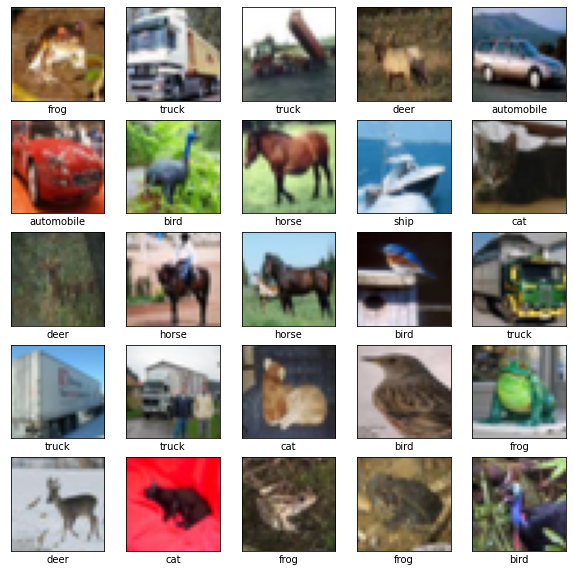

In [ ]:
# let's check what individual samples in the training data look like just for verification

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i][0]])
plt.show()



In [ ]:
def define_model():
  """ This model is fairly simple, feel free to play with this part in pursuit of a better accuracy architecture.
  """
  shape = (32, 32, 3)
  input = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(input)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(10)(x)
  model = Model(input, x)
  return model

In [ ]:
# check model summary
model = define_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [ ]:
# specify parameters
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# train the model
history = model.fit(x_train, y_train,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=10)
history

Epoch 1/10
391/391 [==============================] - 82s 206ms/step - loss: 1.6598 - accuracy: 0.3928 - val_loss: 1.4029 - val_accuracy: 0.4866
Epoch 2/10
391/391 [==============================] - 70s 180ms/step - loss: 1.3068 - accuracy: 0.5346 - val_loss: 1.2563 - val_accuracy: 0.5489
Epoch 3/10
391/391 [==============================] - 72s 185ms/step - loss: 1.1757 - accuracy: 0.5874 - val_loss: 1.1568 - val_accuracy: 0.5978
Epoch 4/10
391/391 [==============================] - 71s 181ms/step - loss: 1.0811 - accuracy: 0.6218 - val_loss: 1.0739 - val_accuracy: 0.6205
Epoch 5/10
391/391 [==============================] - 70s 178ms/step - loss: 1.0103 - accuracy: 0.6483 - val_loss: 1.0241 - val_accuracy: 0.6456
Epoch 6/10
391/391 [==============================] - 72s 185ms/step - loss: 0.9358 - accuracy: 0.6731 - val_loss: 0.9753 - val_accuracy: 0.6634
Epoch 7/10
391/391 [==============================] - 70s 178ms/step - loss: 0.8860 - accuracy: 0.6916 - val_loss: 0.9477 - val_ac

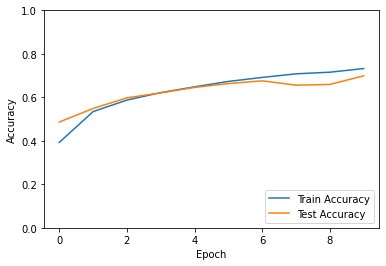

In [ ]:
# evalaute model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
# predict probabilities
import numpy as np
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)
index =0
for p in predictions:
  print( p, np.argmax(p),y_test[index])
  index+=1


Streaming output truncated to the last 5000 lines.
[8.6457044e-04 1.7796812e-04 3.0719928e-02 3.8823668e-02 6.9373116e-02
 1.5874732e-01 6.9888669e-01 2.2123191e-03 7.2757557e-06 1.8705458e-04] 6 [6]
[9.5496047e-01 1.0108231e-03 1.6444500e-03 2.2902882e-03 1.1205671e-03
 1.2997721e-03 6.4952445e-05 3.9957922e-05 3.6079507e-02 1.4892654e-03] 0 [0]
[5.9991267e-05 1.0234096e-04 3.6784715e-03 6.0485780e-02 1.1404000e-01
 6.1997330e-01 2.3366595e-03 1.9923404e-01 3.8124315e-06 8.5565196e-05] 5 [5]
[0.04307502 0.059714   0.04340449 0.08223704 0.00820681 0.23298697
 0.06390467 0.00480053 0.03140511 0.43026525] 9 [0]
[1.9661026e-02 1.9638267e-04 1.4231301e-02 1.6350451e-01 9.9938333e-02
 7.6955773e-02 7.0973480e-04 6.1773342e-01 1.5463200e-03 5.5232262e-03] 7 [7]
[0.16504009 0.10113122 0.2466331  0.04738023 0.05016536 0.01522226
 0.17416753 0.1877008  0.00049375 0.01206579] 2 [7]
[1.6369608e-03 4.9298449e-04 2.1847459e-03 7.2092734e-02 1.1978632e-02
 7.6945499e-02 7.0044170e-03 6.8217313e-01 5